# Churn Prediction
### Goal: predict users who will cancel subscription using different ML algorithms

In [1]:
import pandas as pd
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import random

In [2]:
random.seed(42)
churn_d = pd.read_csv("churn_model\churn_model.csv", sep = ",")
churn_d.head(10)

,user_id,promo_ind,is_auto_prolong,num_operations,duration,operation_BY_TOKEN,operation_REGULAR,churn
0,6,0,0,11,3.3,0,1,0
1,7,0,0,10,59.7,0,1,0
2,10,0,0,7,1.8,0,1,0
3,14,0,1,3,349.6,0,0,0
4,40,0,0,6,20.5,0,1,0
5,72,0,0,6,7.9,0,1,0
6,212,0,0,2,118.4,1,0,0
7,266,0,0,1,25.0,1,0,1
8,446,0,1,1,78.2,0,1,0
9,524,0,1,2,211.4,0,0,0


promo_ind - whether customer obtained subscription in current month using promo code

is_auto_prolong - whether customer ticked autoprolongation option during previous renewal or initial purchase

num_operations - number of previous renewals

duration - overall watch time for 30 previous days

operation type: by token, regular, autoprolongation. Transformed into dummy variables operation_by_token, operation_regular
churn - target

In [3]:
print(churn_d['churn'].value_counts())

0    xxxxx
1    xxxxx
Name: churn, dtype: int64


Roughly xx% of customers in sample cancelled their subscription.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(churn_d.ix[:, ~churn_d.columns.isin(['user_id', 'churn'])],
                                                               churn_d['churn'])

All model training and validation is carried out using grid search and cross validation.

Logistic Regression

In [5]:
pipeline_log =  Pipeline([('clf', LogisticRegression(random_state=42))])
parameters_log = {'clf__penalty': ('l1', 'l2'),
                  'clf__C': (0.01, 0.1, 1, 10),
                  'clf__fit_intercept': (True, False)}

Decision Tree

In [6]:
pipeline_tree = Pipeline([('clf', DecisionTreeClassifier(criterion='entropy', random_state=42))])
parameters_tree = {
                   'clf__max_depth': (150, 155, 160),
                   'clf__min_samples_split': (2, 3, 4),
                   'clf__min_samples_leaf': (2, 3, 4)}

Random Forest

In [7]:
pipeline_forest = Pipeline([('clf', RandomForestClassifier(criterion='entropy', random_state=42))])
parameters_forest = {
                     'clf__n_estimators': (5, 10, 20, 50),
                     'clf__max_depth': (50, 150, 250),
                     'clf__min_samples_split': (2, 3, 4),
                     'clf__min_samples_leaf': (2, 3, 4)}

Naive Bayes

In [8]:
pipeline_bayes = Pipeline([('clf', GaussianNB())])
parameters_bayes = {}

XGBoost

In [9]:
pipeline_xgb = Pipeline([('clf', XGBClassifier(seed=42))])
parameters_xgb = {
                  'clf__max_depth': (3, 6, 10, 25),
                  'clf__learning_rate': (0.1, 0.3, 0.5),
                  'clf__n_estimators': (50, 100, 150)
                  }

SVM

In [10]:
pipeline_svm = Pipeline([#('ss', StandardScaler()),
                         ('clf', SVC(kernel='rbf', probability=True, random_state=42))])
parameters_svm = {
                  'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
                  'clf__C': (0.1, 0.3, 1, 3, 10, 30, 100)
                  }

Neural Net

In [11]:
pipeline_nn = Pipeline([('clf', MLPClassifier(random_state=42))])
parameters_nn = {
                 'clf__activation': ('relu', 'logistic'),
                 'clf__solver': ('sgd', 'adam'),
                 'clf__hidden_layer_sizes': ([2,], [2,2], [100,], [100,150], [200,])
                 }

In [12]:
result = pd.DataFrame()

model_data =    [
                {'name': 'Naive Bayes',
                 'pipeline': pipeline_bayes,
                 'parameters': parameters_bayes,
                 'color': 'y'}, 
                 
                {'name': 'Logistic Regression',
                 'pipeline': pipeline_log,
                 'parameters': parameters_log,
                 'color': 'g'},
                 
                {'name': 'Decision Tree',
                 'pipeline': pipeline_tree,
                 'parameters': parameters_tree,
                 'color': 'r'},
                 
                 {'name': 'Random Forest',
                 'pipeline': pipeline_forest,
                 'parameters': parameters_forest,
                 'color': 'b'},
                 
                 {'name': 'XGBoost',
                  'pipeline': pipeline_xgb,
                  'parameters': parameters_xgb,
                  'color': 'm'},
                  
                 {'name': 'Neural Net',
                  'pipeline': pipeline_nn,
                  'parameters': parameters_nn,
                  'color': 'c'}
                  
#                  {'name': 'SVM',
#                   'pipeline': pipeline_svm,
#                   'parameters': parameters_svm,
#                   'color': 'k'}
                 ]

We will use recall as main cross validation score, because we want to identify as many as possible users in sample who actually cancelled their subscription.

In [13]:
for model in model_data:
    print('\nFitting', model['name'])                
    grid_search = GridSearchCV(model['pipeline'], model['parameters'], n_jobs = -1, verbose = 1, scoring = 'recall')
    grid_search.fit(x_train, y_train)
    predictions = grid_search.predict(x_test)

    #roc curve
    predictions_prob = grid_search.predict_proba(x_test)
    false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_prob[:,1])
    roc_auc = auc(false_positive_rate, recall)
    plt.plot(false_positive_rate, recall, model['color'], label = 'AUC %s = %0.2f' % (model['name'], roc_auc))
    plt.plot([0,1], [0,1], 'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.title('ROC Curve')
    temp = pd.DataFrame({'1.Best grid search score': grid_search.best_score_,
                         '2.Accuracy': accuracy_score(y_test, predictions),
                         '3.Precision': precision_score(y_test, predictions),
                         '4.Recall': recall_score(y_test, predictions),
                         '6.AUC': roc_auc,
                         '5.F1': f1_score(y_test, predictions),
                         }, index = [model['name']])
    result = result.append(temp)


Fitting Naive Bayes
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished



Fitting Logistic Regression
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.1s finished



Fitting Decision Tree
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    6.7s finished



Fitting Random Forest
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  1.2min finished



Fitting XGBoost
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.3min finished



Fitting Neural Net
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


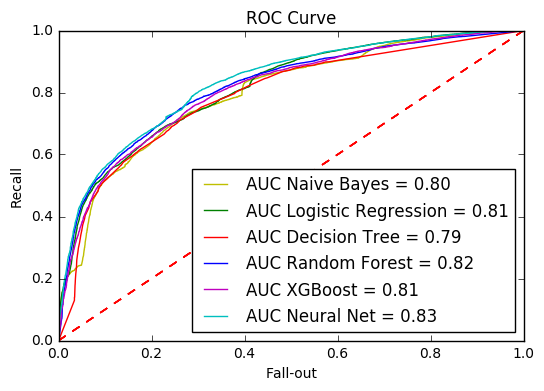

,1.Best grid search score,2.Accuracy,3.Precision,4.Recall,5.F1,6.AUC
Naive Bayes,0.760865,0.698964,0.595119,0.767830,0.670532,0.797764
Logistic Regression,0.610942,0.746543,0.710070,0.616379,0.659916,0.813941
Decision Tree,0.615521,0.740355,0.695732,0.620609,0.656027,0.789560
Random Forest,0.637943,0.756106,0.722431,0.631183,0.673732,0.816940
XGBoost,0.634429,0.744949,0.696342,0.639643,0.666789,0.808473
Neural Net,0.700154,0.750621,0.687419,0.687581,0.687500,0.831064


In [14]:
plt.show()
result

We will go with neural net as the best model for current task, because it has highest AUC, F1 scores and second best accuracy.

It has second worst precision which means that 69% of customers who we named as churn, actually cancelled their subscription. But neural net has the best recall after naive bayes which means that it can correctly identify 69% of actual churn.

For this task we may accept this trade-off, because we are more interested in actual churn.